In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
from scipy.signal import convolve
import scipy
from joblib import Parallel, delayed
import time
import sys
from scipy import sparse
import json
from tqdm import tqdm, tqdm_notebook
import matplotlib.gridspec as gridspec
import os
sys.path.insert(0, "../Scripts")
# from antigenicWaveSimulationMethods import main as coEvoSimulation
from coverage import elementwise_coverage, coverage_1D
from fitness import fitness, norm_fitness, phage_growth
from altImmunity import immunity_loss_uniform, immunity_gain_from_kernel
from immunity import immunity_mean_field_1D
from initMethods import init_trail_nh, init_1D_kernel, init_guassian_n, init_cond
from supMethods import time_conv, write2json
from mutation import mutation
from randomHGT import HGT_logistic_event

In [18]:
params = { #parameters relevant for the equations
        "Nh":                     1E7,
        "N0":                     1E9, #This Will be updated by self-consitent solution
        "R0":                      20, 
        "M":                        5, #Also L, total number of spacers
        "mu":                      10, #mutation rate
        "gamma_shape":             20,
        "Np":                      10, #Number of Cas Protein
        "dc":                      10, #Required number of complexes to activate defence
        "h":                       10, #coordination coeff
        "r":                     1000, #cross-reactivity kernel
        "beta":                     0,
        "rate_HGT":                 0,
        "HGT_bonus_acq_ratio":      0,
        "rate_recovery":            0,
        "HGT_type":                 0,
        "n_spacer":                 1,
        "A":                        1,
    }
sim_params = { #parameters relevant for the simulation (including Inital Valuess)
        "continue":                 False, #DO NOT CREATE ARBITRARY FOLDERS ONLY FOR TESTS
        "xdomain":                 100000,
        "dim":                          1,
        "dx":                           1,
        "tf":                        4000,
        "dt":                           1,
        "dt_exact_fitness":             1,
        "dt_snapshot":                  1,
        "initial_mean_n":           [0,0],
        "initial_mean_nh":          [0,0],
        "conv_size":                 4000,
        "num_threads":                 32,
        "foldername":   "../Data_1D_Test",
        "seed":                         34,
        "hard_N0":                   False,
        "ndim":                         1,
    }

In [19]:
params, sim_params = init_cond(params, sim_params)
foldername = sim_params["foldername"]

try:
    write2json(foldername, params, sim_params)
except FileNotFoundError:
    os.mkdir(foldername)
    write2json(foldername, params, sim_params)


Assumptions Checks: 
mu >> 1 : mu = 10 >> 1
del_x << r : gamma_shape = 20 << r = 1000
v*tau >> sigma : v*tau = 521.1246536102815 >> sigma = 28.928983746384073
uc << r : uc = 115.91622872301745 << r = 1000


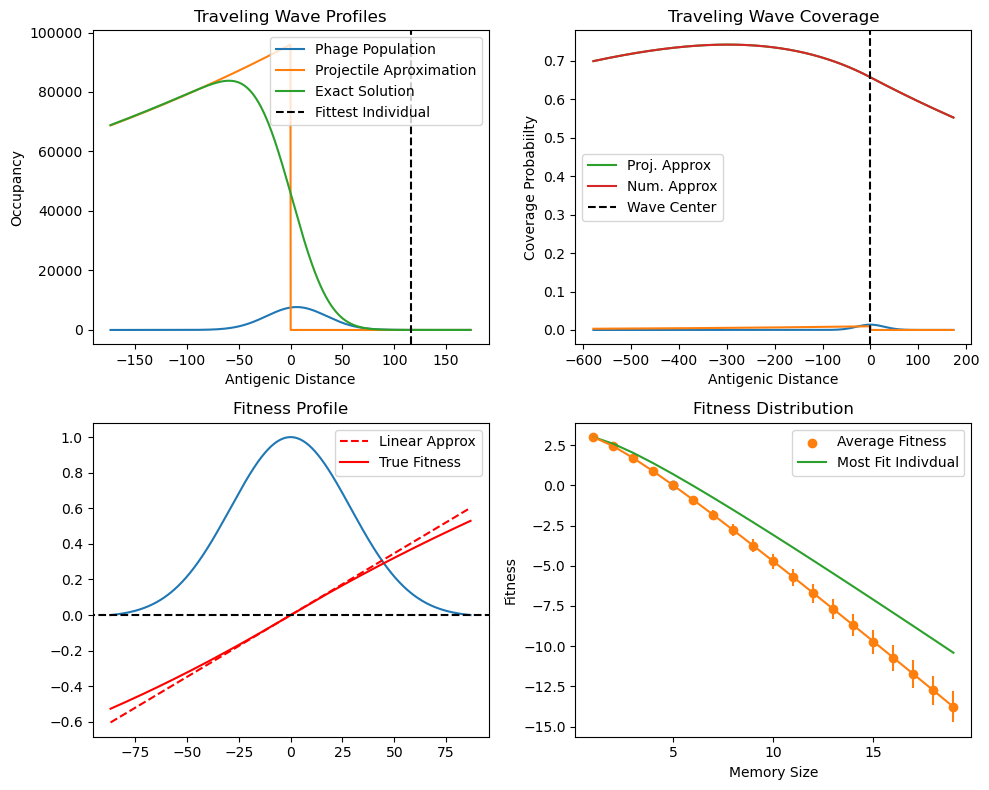

In [20]:
from formulas import plot_fitness_memory_dynamics, plot_wave_coverage, plot_wave_fitness, plot_wave_profiles
fig = plt.figure(figsize=(10, 8))

# Define the grid layout with 3 rows and 3 columns
gs = gridspec.GridSpec(2, 2)

# Create the first two rows (2x2 grid)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

# Plot something in each subplot
plot_wave_profiles(params, sim_params, ax1)
plot_wave_coverage(params, sim_params, ax2)
plot_wave_fitness(params, sim_params, ax3)
plot_fitness_memory_dynamics(params, sim_params, ax4)

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
st1 = time.time()
n = init_guassian_n(params, sim_params)
nh = init_trail_nh(params, sim_params, exact=False)
kernel_1D = init_1D_kernel(params, sim_params)
ed = time.time()
            
nh_total = params["Nh"]
n_total = params["N"]
uc = params["uc"]
sigma = params["sigma"]
M0 = params["M0"]
t = 0

folder = sim_params["foldername"]
np.save(folder + "/frame_nh0.npy", nh)
# nh = np.load(folder + "/frame_nh0.npy")

np.save(folder + "/frame_n0.npy", n)
# n = np.load(folder + "/frame_n0.npy")
with open(foldername+'/runtime_stats.txt','w') as file:
    file.write(f't: {t}| init_functions: {time_conv(ed-st1)}| Phage Population: {n_total:.4f}| Spacer Population: {nh_total:.4f}| Uc: {uc:.4f}| sigma: {sigma:.4f}| M0: {M0:.4f} \n')

(-500.0, 500.0)

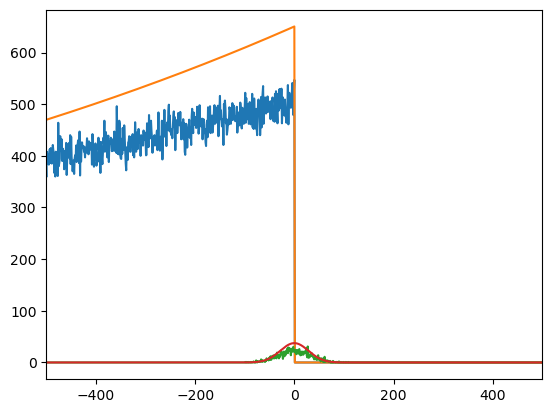

In [6]:
from formulas import gaussian1D, semi_exact_nh, trail_exp
xdomain = sim_params["xdomain"]
dx = sim_params["dx"]
x_range = np.arange(-xdomain, xdomain, dx)

plt.plot(x_range, nh)
plt.plot(x_range, trail_exp(x_range, 0, params, sim_params))
plt.plot(x_range, n)
plt.plot(x_range, gaussian1D(x_range, 0, params, sim_params))
plt.xlim(-500, 500)

In [7]:
while(t < sim_params["tf"]):
    
    np.save(folder+f"/frame_n{t}.npy", n)
    np.save(folder+f"/frame_nh{t}.npy", nh)

    str1:float = time.time()
    p = coverage_1D(nh, kernel_1D, params, sim_params)

    st2 = time.time()
    f = fitness(n, p, params, sim_params)
    f = norm_fitness(f, n, params, sim_params) #renormalize f
    n = phage_growth(n, f, params, sim_params, True) #update
            
    if (np.sum(n) <= 0) or (np.sum(n) >= (1/2)*np.sum(nh)):
        with open(foldername+'/runtime_stats.txt','a') as file:
            outstring = f"DEAD at: {t}| N: {np.sum(n)}| Coverage: {time_conv(st2-st1)}| Growth: {time_conv(st3-st2)}| Mutation: {time_conv(st4-st3)}| Immunity: {time_conv(ed-st4)} \n"
            file.write(outstring)

    st3 = time.time()
    n = mutation(n, params, sim_params)

    st4 = time.time()
    nh_prev = nh
    
    # params, sim_params, num_to_add, num_to_remove = HGT_logistic_event(t, n, params, sim_params)
    # nh_gain = immunity_gain_from_kernel(nh, n, None, params, sim_params, num_to_add) #update nh
    # nh = immunity_loss_uniform(nh_gain, n, params, sim_params, num_to_remove)
    nh = immunity_mean_field_1D(nh, n, params, sim_params)
    # diff_of_acquisition = num_to_add-num_to_remove
    diff_of_acquisition = 0
    ed = time.time()

    with open(foldername+'/runtime_stats.txt','a') as file:
        M = params["M"]
        outstring = f"t: {t}| N: {np.sum(n)}| Coverage: {time_conv(st2-st1)}| Growth: {time_conv(st3-st2)}| Mutation: {time_conv(st4-st3)}| Immunity: {time_conv(ed-st4)}| M: {M:.4f}| Net_Acq_Diff: {diff_of_acquisition:.4f} \n"
        file.write(outstring)

    t += sim_params["dt"]

ValueError: a must be 1-dimensional

In [6]:
params["Nh"]*params["M"]

1000000.0